# Evaluating xTrimoGene in zero-shot setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
env_path = "%s/../" % os.path.dirname(os.path.abspath(".")) 
sys.path.append(env_path)

env_path = "%s/../xTrimoGene/preprocessing" % os.path.dirname(os.path.abspath(".")) 
sys.path.append(env_path)

In [3]:
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import cell_embeddings, scgpt_forward, data, model_output
from sc_foundation_evals.helpers.custom_logging import log
from sc_foundation_evals.utils import eval_scib_metrics

log.setLevel(logging.INFO)

# Define variables

In [10]:
use_rep_key = "X_xtrimo"
label_col = "celltype"

# Preprocess data

In [4]:
from scRNA_workflow import *
sc.settings.figdir='../../output/xTrimoGene/figures_new/' # set figure folder
dataset_path = "../../data/datasets/pancreas_scib.h5ad"
adata = sc.read_h5ad(dataset_path) # origin: read from 10x file

In [5]:
adata.X.shape

(16382, 19093)

In [6]:
X_df= pd.DataFrame(adata.X,index=adata.obs.index.tolist(),columns=adata.var.index.tolist()) # read from csv file
gene_list_df = pd.read_csv('../../xTrimoGene/OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])
X_df, to_fill_columns, var = main_gene_selection(X_df, gene_list)
adata_uni = sc.AnnData(X_df)
adata_uni.obs = adata.obs
adata_uni.uns = adata.uns

In [9]:
X_df.shape

(16382, 19264)

In [8]:
save_path = "../../data/datasets/xTrimoGene/pancreas_scib_19264.npy"
# X_df.to_csv('./samples.csv', header=True, index=True)
np.save(save_path, X_df.to_numpy())

In [10]:
# filter genes and cells
adata_uni = BasicFilter(adata_uni,qc_min_genes=200,qc_min_cells=0) # filter cell and gene by lower limit
adata_uni = QC_Metrics_info(adata_uni)

Before filter, 16382 Cells, 19264 Genes
After filter, 16382 Cells, 19264 Genes


In [11]:
adata_uni.X.shape

(16382, 19264)

In [14]:
adata_uni.var["gene_name"] = adata_uni.var.index
adata_uni.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,gene_name
A1BG,3178,False,3178,0.376716,80.600659,6171.361294,A1BG
A1CF,5937,False,5937,1.047439,63.759004,17159.140281,A1CF
A2M,789,False,789,0.132378,95.183738,2168.624016,A2M
A2ML1,487,False,487,0.018926,97.027225,310.053375,A2ML1
A3GALT2,0,False,0,0.000000,100.000000,0.000000,A3GALT2
...,...,...,...,...,...,...,...
ZYG11A,0,False,0,0.000000,100.000000,0.000000,ZYG11A
ZYG11B,6073,False,6073,0.939624,62.928824,15392.923367,ZYG11B
ZYX,5334,False,5334,1.050379,67.439873,17207.314048,ZYX
ZZEF1,5093,False,5093,0.724467,68.911000,11868.215322,ZZEF1


In [15]:
save_path = "../../data/datasets/xTrimoGene/pancreas_scib_19264.h5ad"
save_adata_h5ad(adata_uni,save_path, shrink_to_sparse=True)

Current data saved


# Extract cell embedding

In [17]:
os.system("bash ../scripts/run_xTrimoGene_embed.sh")

(16382, 19264)
{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPla

 15%|█▌        | 2470/16382 [10:18<41:00,  5.65it/s]  

In [4]:
save_path = "../../data/datasets/xTrimoGene/pancreas_scib_19264.h5ad"
adata = sc.read_h5ad(save_path)
adata

AnnData object with n_obs × n_vars = 16382 × 19264
    obs: 'tech', 'celltype', 'size_factors', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_name'

In [5]:
cell_embeddings = np.load("../../output/xTrimoGene/pancreas_scib_01B-resolution_singlecell_cell_embedding_f1_resolution.npy")
adata.obsm["X_xtrimo"] = cell_embeddings

In [6]:
cell_embeddings.shape

(16382, 3072)

## Clustering metrics

In [ ]:
eval_scib_metrics(adata, batch_key=batch_col, label_key=label_col, embedding_key=use_rep_key)

## Reference mapping and transfer the annotations

1. extract cell embeddings: bash ./scFoundation/zero-shot-scfoundation/scripts/run_UCE_embed.sh

2. run the notebook

In [7]:
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [9]:
ref_batch = ['indrop', 'celseq2', 'celseq']
adata.obs["is_ref"] = adata.obs["batch"].isin(ref_batch)
adata.obs

,tech,celltype,size_factors,batch,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,is_ref
D101_5,celseq,gamma,0.028492,celseq,1764,1764,6859.111145,0.0,0.0,True
D101_43,celseq,gamma,0.079348,celseq,3515,3515,10821.695002,0.0,0.0,True
D101_93,celseq,gamma,0.037932,celseq,2137,2137,7778.691295,0.0,0.0,True
D102_4,celseq,gamma,0.047685,celseq,2490,2490,8592.996779,0.0,0.0,True
D172444_23,celseq,gamma,0.038683,celseq,2101,2101,7613.811651,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...
Sample_1594,smarter,gamma,1.000000,smarter,5415,5415,12309.416779,0.0,0.0,False
Sample_1595,smarter,gamma,1.000000,smarter,4837,4837,11925.626879,0.0,0.0,False
Sample_1597,smarter,gamma,1.000000,smarter,5941,5941,13942.315556,0.0,0.0,False
Sample_1598,smarter,gamma,1.000000,smarter,3870,3870,10394.009186,0.0,0.0,False


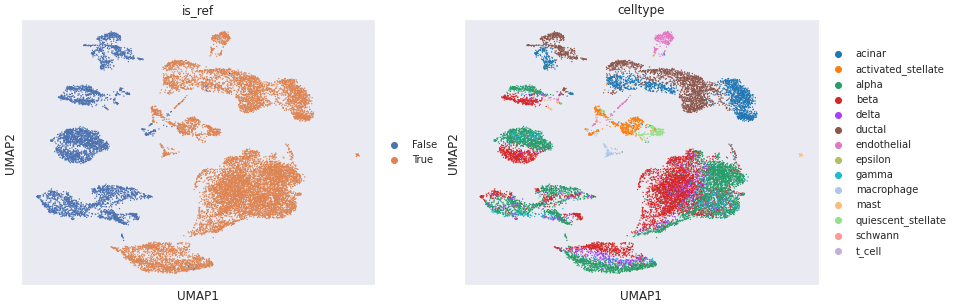

In [11]:
#! plot the figure using sc.tl.umap or plt.scatter
adata.obs["is_ref"] = adata.obs["is_ref"].astype("category")
sc.pp.neighbors(adata, use_rep=use_rep_key)
sc.tl.umap(adata)
fig = sc.pl.umap(
    adata, color=["is_ref", "celltype"], layer=use_rep_key,
    # wspace=0.4, frameon=True, ncols=1,
    return_fig=True
)
fig.tight_layout()
# fig.savefig("../../output/geneformer/6L/test.png")

In [12]:
ref_adata = adata[np.where(adata.obs["batch"].isin(ref_batch))[0]]
test_adata = adata[~np.where(adata.obs["batch"].isin(ref_batch))[0]]

In [14]:
ref_cell_embeddings = ref_adata.obsm[use_rep_key]
test_emebd = test_adata.obsm[use_rep_key]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    idx = labels[k]
    pred = ref_adata.obs[label_col][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[label_col].to_numpy()

In [15]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}
res_dict

{'accuracy': 0.8604317760161916,
 'precision': 0.9152625205601328,
 'recall': 0.7526182966103366,
 'macro_f1': 0.7924477004455681}

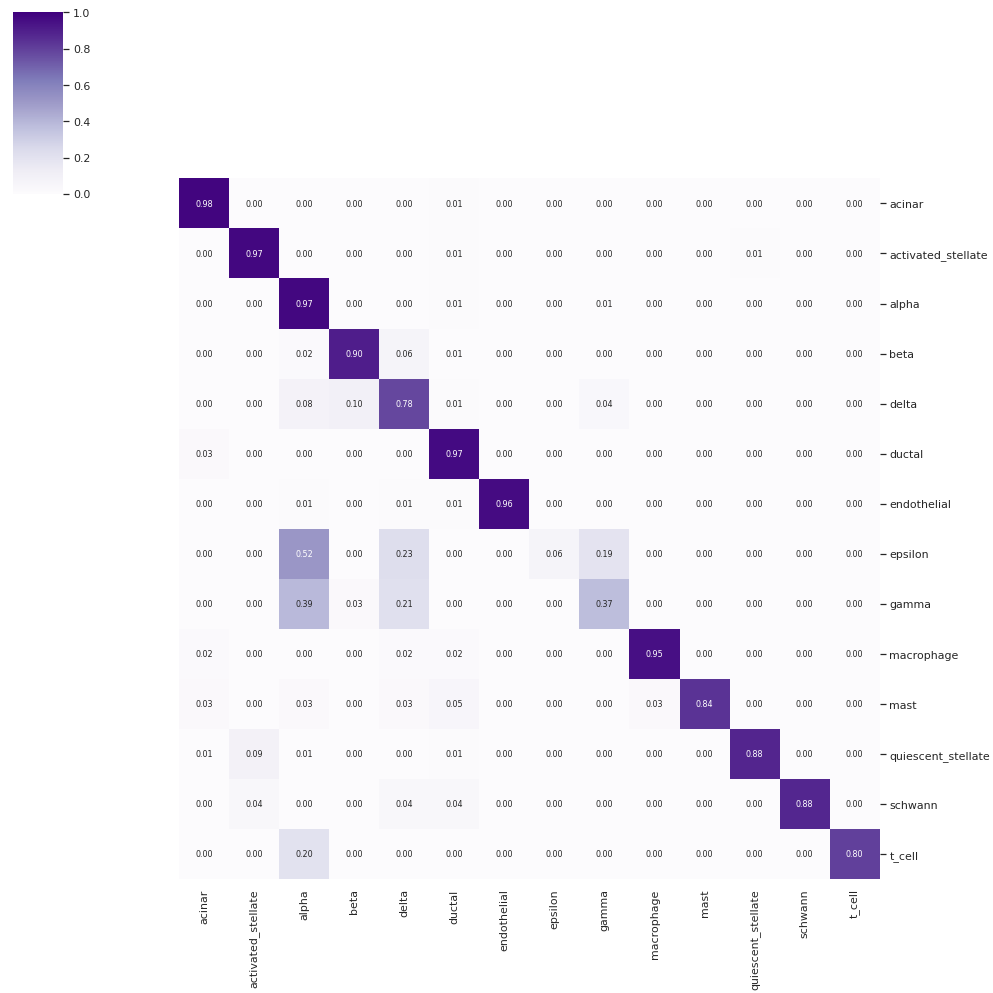

In [24]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14),
                    )